# Imports

In [1]:
%matplotlib inline

import os
import sys
from ipywidgets import interact, FloatSlider

import dynaphos
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from IPython.display import clear_output

import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import math

from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos import cortex_models

sys.path.append(os.path.abspath(os.path.join('..')))

from utils import resize

import local_datasets
from torch.utils.data import Subset, DataLoader

from utils import (
    CustomSummaryTracker,
    dilation3x3,
    resize,
    tensor_to_rgb,
    undo_standardize,
)

import importlib

from time import time

from torchinfo import summary

# Face Data

In [2]:
importlib.reload(local_datasets)

<module 'local_datasets' from '/gpfs/home1/mappel/Dynaphos/viseon/local_datasets.py'>

In [3]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

cfg = load_config('../_config/exp-local/faces_boundary_supervised_phosphenes_no_decoder.yaml')
cfg['retinal_compression'] = True
cfg['data_directory'] = '../../data/face/LaPa'
cfg['base_config'] = '../_config/exp-local/params.yaml'
cfg['phosphene_map'] = '../_config/phosphene_maps/DefaultCoordinateMap_1000_phosphenes.pickle'
cfg['batch_size'] = 1
cfg['fov'] = 5
cfg['resolution'] = [256, 256]
cfg['output_scaling'] = 1.e-4
cfg['n_electrodes'] = 1024
params = dynaphos.utils.load_params(cfg['base_config'])
params['run']['batch_size'] = cfg['batch_size']

cfg['retinal_compression'] = False
cfg['imsize'] = [128, 128]
cfg['fov'] = 5
cfg['circular_mask'] = False

In [4]:
trainset, valset = local_datasets.get_lapa_dataset(cfg)

trainloader = DataLoader(trainset, batch_size=cfg['batch_size'], shuffle=True, drop_last=True)
valloader = DataLoader(valset, batch_size=cfg['batch_size'], shuffle=True, drop_last=True)

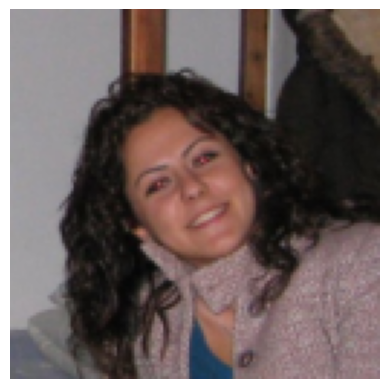

In [5]:
example_batch = next(iter(valloader))

plt.imshow(example_batch['image'][0].permute(1,2,0).cpu())
plt.axis('off')
plt.show()

# Simulator

In [6]:
def get_simulator(cfg, phosphene_coords=None):
    # initialise simulator

    params = dynaphos.utils.load_params(cfg['base_config'])
    params['run']['batch_size'] = cfg['batch_size']

    if phosphene_coords is None:
        n_phosphenes = cfg['n_electrodes']
        phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

    simulator = PhospheneSimulator(params, phosphene_coords)
    return simulator

n_phosphenes = cfg['n_electrodes']
params = dynaphos.utils.load_params(cfg['base_config'])
params['batch_size'] = 4
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = get_simulator(cfg, phosphene_coords=phosphene_coords)
cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
len(simulator.phosphene_maps)

1024

In [7]:
cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
print(f"Phosphene map size: {cfg['SPVsize']}")
N_PHOSPHENES = simulator.num_phosphenes
print(f"Number of phosphenes: {N_PHOSPHENES}")

Phosphene map size: torch.Size([256, 256])
Number of phosphenes: 1024


In [8]:
x, y = phosphene_coords._x, phosphene_coords._y
coords = torch.Tensor(np.array([x, y]))

In [9]:
reshape_square = np.sqrt(N_PHOSPHENES)

# if the sqrt is not an integer, we need to find the closest integer that is bigger
if int(reshape_square) != reshape_square:
    reshape_square = int(reshape_square) + 1
else:
    reshape_square = int(reshape_square)
    
reshape_square

32

In [10]:
# Function to update the plot based on the slider values
def update_plot(shift_x=0.5, shift_y=0.5, scale=20):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    shifted_image = torch.roll(face_image, int(shift_x * face_image.shape[-1]), dims=-1)
    shifted_image = torch.roll(shifted_image, int(shift_y * face_image.shape[-2]), dims=-2)
    
    # scale content and fit into original image size
    if scale > 0 and scale < 1.:
        scaled_image = F.interpolate(shifted_image, scale_factor=scale, mode='nearest')
        shifted_image = torch.zeros((1, 1, *cfg['imsize']), device=cfg['device'])
        shifted_image[0, 0, 
                    int((cfg['imsize'][0] - scaled_image.shape[-2]) / 2):int((cfg['imsize'][0] + scaled_image.shape[-2]) / 2), 
                    int((cfg['imsize'][1] - scaled_image.shape[-1]) / 2):int((cfg['imsize'][1] + scaled_image.shape[-1]) / 2)] = scaled_image
    elif scale == 0.: # no scaling
        shifted_image = torch.zeros((1, 1, *cfg['imsize']), device=cfg['device'])
    elif scale > 1.:
        scaled_image = F.interpolate(shifted_image, scale_factor=scale, mode='nearest')
        # crop
        shifted_image = scaled_image[:, :,
                    int((scaled_image.shape[-2] - cfg['imsize'][0]) / 2):int((scaled_image.shape[-2] + cfg['imsize'][0]) / 2),
                    int((scaled_image.shape[-1] - cfg['imsize'][1]) / 2):int((scaled_image.shape[-1] + cfg['imsize'][1]) / 2)]
        
    # Update the visual input display
    ax[0].imshow(shifted_image[0].permute(1,2,0).cpu().numpy(), cmap='gray')
    ax[0].set_title('Visual Input')
    ax[0].axis('off')
    
    # Update the phosphene display
    resized_image = resize(shifted_image, cfg['SPVsize'], interpolation='nearest')
    stimulation = simulator.sample_centers(resized_image.mean(1, keepdim=True)) * cfg['output_scaling']
    simulator.reset()
    phosphenes = simulator(stimulation).unsqueeze(1)
    
    ax[1].imshow(phosphenes.squeeze().detach().cpu().numpy(), cmap='gray')
    ax[1].set_title('Phosphenes')
    ax[1].axis('off')
    
    # Update the stimulation display
    stimulation_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
    stimulation_square.view(-1)[:N_PHOSPHENES] = stimulation

    ax[2].imshow(stimulation_square.cpu().numpy(), cmap='gray')
    ax[2].set_title('Stimulation')
    ax[2].axis('off')

    plt.show()


# Generate the circle image with the specified size
face_image = example_batch['contour'].to(cfg['device'])
face_image = dilation3x3(face_image)

# Display the interactive widgets
plot = interact(update_plot, 
         shift_x=FloatSlider(min=-0.5, max=0.5, step=0.001, value=0., description='Shift X'), 
         shift_y=FloatSlider(min=-0.5, max=0.5, step=0.001, value=0., description='Shift Y'),
         scale=FloatSlider(min=0.0, max=3.0, step=0.001, value=1., description='Scale'))

interactive(children=(FloatSlider(value=0.0, description='Shift X', max=0.5, min=-0.5, step=0.001), FloatSlide…

# Retinal Encoder

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, n_channels, stride=1, resample_out=None, groups=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(n_channels)
        self.resample_out = resample_out

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        if self.resample_out:
            out = self.resample_out(out)
        return out
    
def convlayer(n_input, n_output, k_size=3, stride=1, padding=1, resample_out=None, groups=1):
    layer = [
        nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, groups=groups, bias=False),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
        resample_out]
    if resample_out is None:
        layer.pop()
    return layer

def pointwise_convlayer(n_input, n_output, resample_out=None):
    return convlayer(n_input, n_output, k_size=1, stride=1, padding=0, resample_out=resample_out, groups=1)

class Retinal_Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, n_electrodes=1024, out_scaling=1e-4, out_activation='relu'):
        super(Retinal_Encoder, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(), ## NOTE: simulator expects only positive stimulation values 
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]


        # self.model = nn.Sequential(*convlayer(in_channels,8,3,1,1),
        #                            *convlayer(8,16,3,1,1,resample_out=nn.MaxPool2d(2)),
        #                            *convlayer(16,32,3,1,1,resample_out=nn.MaxPool2d(2)),
        #                            ResidualBlock(32, resample_out=None),
        #                            ResidualBlock(32, resample_out=None),
        #                            ResidualBlock(32, resample_out=None),
        #                            ResidualBlock(32, resample_out=None),
        #                            *convlayer(32,16,3,1,1),
        #                            nn.Conv2d(16,1,3,1,1),
        #                            nn.Flatten(),
        #                            nn.Linear(1024,n_electrodes),
        #                            self.out_activation)
        

        # self.model = nn.Sequential(
        #     *convlayer(in_channels,8,3,1,1),
        #     *convlayer(8,16,3,1,1,resample_out=nn.MaxPool2d(2), groups=1),
        #     *convlayer(16,32,3,1,1,resample_out=nn.MaxPool2d(2), groups=1),
        #     ResidualBlock(32, resample_out=None, groups=1),
        #     ResidualBlock(32, resample_out=None, groups=1),
        #     ResidualBlock(32, resample_out=None, groups=1),
        #     ResidualBlock(32, resample_out=None, groups=32),
        #     *convlayer(32, 32, 1, 1, 0, groups=1),
        #     *convlayer(32, 32, 2, 2, 0, groups=16),
        #     *convlayer(32, 32, 1, 1, 0, groups=1),
        #     *convlayer(32, 64, 2, 2, 0, groups=32),
        #     *convlayer(64, 64, 1, 1, 0, groups=1),
        #     *convlayer(64, 128, 2, 2, 0, groups=32),
        #     *convlayer(128, 128, 1, 1, 0, groups=1),
        #     *convlayer(128, 256, 2, 2, 0, groups=64),
        #     *convlayer(256, 256, 1, 1, 0, groups=1),
        #     nn.Conv2d(256, 1024, 2, 1, 0, bias=True, groups=64),
        #     self.out_activation
        # )

        # self.model = nn.Sequential(
        #     *convlayer(in_channels,8,3,1,1, groups=1),
        #     *convlayer(8,16,3,1,1,resample_out=nn.MaxPool2d(2), groups=1),
        #     *convlayer(16,32,3,1,1,resample_out=nn.MaxPool2d(2), groups=1),
        #     ResidualBlock(32, resample_out=None, groups=1),
        #     ResidualBlock(32, resample_out=None, groups=1),
        #     ResidualBlock(32, resample_out=None, groups=1),
        #     ResidualBlock(32, resample_out=None, groups=1),
        #     *convlayer(32, 64, 2, 2, 0, groups=1),
        #     *convlayer(64, 128, 2, 2, 0, groups=32),
        #     *convlayer(128, 256, 2, 2, 0, groups=64),
        #     nn.Conv2d(256, 1024, 2, 1, 0, bias=False, groups=128),
        #     self.out_activation
        # )

        self.n_electrodes = n_electrodes
        self.fc = None
            
    def forward(self, x):
        stimulation = self.model(x)
        return stimulation.squeeze(-1).squeeze(-1) * self.output_scaling


retinal_encoder = Retinal_Encoder(n_electrodes=cfg['n_electrodes'], out_scaling=cfg['output_scaling'], out_activation='relu').to(cfg['device'])
torch.use_deterministic_algorithms(False)

# test forward pass
output = retinal_encoder(torch.randn(1, 3, 128, 128).to(cfg['device']))

print('out size:', output.shape)
print(output.min(), output.max(), '\n')

out size: torch.Size([1, 1024, 3, 3])
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0004, device='cuda:0', grad_fn=<MaxBackward1>) 



In [17]:
summary(retinal_encoder, input_size=(1, 3, 128, 128)) 

Layer (type:depth-idx)                   Output Shape              Param #
Retinal_Encoder                          [1, 1024, 3, 3]           --
├─Sequential: 1-1                        [1, 1024, 3, 3]           --
│    └─Conv2d: 2-1                       [1, 8, 128, 128]          216
│    └─BatchNorm2d: 2-2                  [1, 8, 128, 128]          16
│    └─LeakyReLU: 2-3                    [1, 8, 128, 128]          --
│    └─Conv2d: 2-4                       [1, 16, 128, 128]         1,152
│    └─BatchNorm2d: 2-5                  [1, 16, 128, 128]         32
│    └─LeakyReLU: 2-6                    [1, 16, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 16, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 32, 64, 64]           4,608
│    └─BatchNorm2d: 2-9                  [1, 32, 64, 64]           64
│    └─LeakyReLU: 2-10                   [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-11                   [1, 32, 32, 32]           --
│    └─R

In [18]:
retinal_encoder.eval()
input = torch.randn(1, 3, 128, 128).to(cfg['device'])
%timeit retinal_encoder(input)

1.67 ms ± 918 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
# ==========================================================================================
# Layer (type:depth-idx)                   Output Shape              Param #
# ==========================================================================================
# Retinal_Encoder                          [1, 1024]                 --
# ├─Sequential: 1-1                        [1, 1024]                 --
# │    └─Conv2d: 2-1                       [1, 8, 128, 128]          216
# │    └─BatchNorm2d: 2-2                  [1, 8, 128, 128]          16
# │    └─LeakyReLU: 2-3                    [1, 8, 128, 128]          --
# │    └─Conv2d: 2-4                       [1, 16, 128, 128]         1,152
# │    └─BatchNorm2d: 2-5                  [1, 16, 128, 128]         32
# │    └─LeakyReLU: 2-6                    [1, 16, 128, 128]         --
# │    └─MaxPool2d: 2-7                    [1, 16, 64, 64]           --
# │    └─Conv2d: 2-8                       [1, 32, 64, 64]           4,608
# │    └─BatchNorm2d: 2-9                  [1, 32, 64, 64]           64
# │    └─LeakyReLU: 2-10                   [1, 32, 64, 64]           --
# │    └─MaxPool2d: 2-11                   [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-12               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-1                  [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-2             [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-3               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-4                  [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-5             [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-6               [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-13               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-7                  [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-8             [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-9               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-10                 [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-11            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-12              [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-14               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-13                 [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-14            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-15              [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-16                 [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-17            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-18              [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-15               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-19                 [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-20            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-21              [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-22                 [1, 32, 32, 32]           9,248
# │    │    └─BatchNorm2d: 3-23            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-24              [1, 32, 32, 32]           --
# │    └─Conv2d: 2-16                      [1, 16, 32, 32]           4,608
# │    └─BatchNorm2d: 2-17                 [1, 16, 32, 32]           32
# │    └─LeakyReLU: 2-18                   [1, 16, 32, 32]           --
# │    └─Conv2d: 2-19                      [1, 1, 32, 32]            145
# │    └─Flatten: 2-20                     [1, 1024]                 --
# │    └─Linear: 2-21                      [1, 1024]                 1,049,600
# │    └─ReLU: 2-22                        [1, 1024]                 --
# ==========================================================================================
# Total params: 1,134,969
# Trainable params: 1,134,969
# Non-trainable params: 0
# Total mult-adds (M): 122.96
# ==========================================================================================
# Input size (MB): 0.20
# Forward/backward pass size (MB): 12.86
# Params size (MB): 4.54
# Estimated Total Size (MB): 17.60
# ==========================================================================================
# 1.5 ms ± 871 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

# ==========================================================================================
# Layer (type:depth-idx)                   Output Shape              Param #
# ==========================================================================================
# Retinal_Encoder                          [1, 1024]                 --
# ├─Sequential: 1-1                        [1, 1024, 1, 1]           --
# │    └─Conv2d: 2-1                       [1, 8, 128, 128]          216
# │    └─BatchNorm2d: 2-2                  [1, 8, 128, 128]          16
# │    └─LeakyReLU: 2-3                    [1, 8, 128, 128]          --
# │    └─Conv2d: 2-4                       [1, 16, 128, 128]         144
# │    └─BatchNorm2d: 2-5                  [1, 16, 128, 128]         32
# │    └─LeakyReLU: 2-6                    [1, 16, 128, 128]         --
# │    └─MaxPool2d: 2-7                    [1, 16, 64, 64]           --
# │    └─Conv2d: 2-8                       [1, 32, 64, 64]           288
# │    └─BatchNorm2d: 2-9                  [1, 32, 64, 64]           64
# │    └─LeakyReLU: 2-10                   [1, 32, 64, 64]           --
# │    └─MaxPool2d: 2-11                   [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-12               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-1                  [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-2             [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-3               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-4                  [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-5             [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-6               [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-13               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-7                  [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-8             [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-9               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-10                 [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-11            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-12              [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-14               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-13                 [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-14            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-15              [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-16                 [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-17            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-18              [1, 32, 32, 32]           --
# │    └─ResidualBlock: 2-15               [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-19                 [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-20            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-21              [1, 32, 32, 32]           --
# │    │    └─Conv2d: 3-22                 [1, 32, 32, 32]           320
# │    │    └─BatchNorm2d: 3-23            [1, 32, 32, 32]           64
# │    │    └─LeakyReLU: 3-24              [1, 32, 32, 32]           --
# │    └─Conv2d: 2-16                      [1, 32, 16, 16]           128
# │    └─BatchNorm2d: 2-17                 [1, 32, 16, 16]           64
# │    └─LeakyReLU: 2-18                   [1, 32, 16, 16]           --
# │    └─Conv2d: 2-19                      [1, 64, 8, 8]             256
# │    └─BatchNorm2d: 2-20                 [1, 64, 8, 8]             128
# │    └─LeakyReLU: 2-21                   [1, 64, 8, 8]             --
# │    └─Conv2d: 2-22                      [1, 128, 4, 4]            512
# │    └─BatchNorm2d: 2-23                 [1, 128, 4, 4]            256
# │    └─LeakyReLU: 2-24                   [1, 128, 4, 4]            --
# │    └─Conv2d: 2-25                      [1, 256, 2, 2]            2,048
# │    └─BatchNorm2d: 2-26                 [1, 256, 2, 2]            512
# │    └─LeakyReLU: 2-27                   [1, 256, 2, 2]            --
# │    └─Conv2d: 2-28                      [1, 1024, 1, 1]           4,096
# │    └─ReLU: 2-29                        [1, 1024, 1, 1]           --
# ==========================================================================================
# Total params: 11,832
# Trainable params: 11,832
# Non-trainable params: 0
# Total mult-adds (M): 9.77
# ==========================================================================================
# Input size (MB): 0.20
# Forward/backward pass size (MB): 12.84
# Params size (MB): 0.05
# Estimated Total Size (MB): 13.08
# ==========================================================================================
# 1.47 ms ± 570 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

# ==========================================================================================
# Layer (type:depth-idx)                   Output Shape              Param #
# ==========================================================================================
# Retinal_Encoder                          [1, 1024]                 --
# ├─Sequential: 1-1                        [1, 1024, 1, 1]           --
# │    └─Conv2d: 2-1                       [1, 8, 64, 64]            216
# │    └─BatchNorm2d: 2-2                  [1, 8, 64, 64]            16
# │    └─LeakyReLU: 2-3                    [1, 8, 64, 64]            --
# │    └─Conv2d: 2-4                       [1, 16, 64, 64]           144
# │    └─BatchNorm2d: 2-5                  [1, 16, 64, 64]           32
# │    └─LeakyReLU: 2-6                    [1, 16, 64, 64]           --
# │    └─MaxPool2d: 2-7                    [1, 16, 32, 32]           --
# │    └─Conv2d: 2-8                       [1, 32, 32, 32]           288
# │    └─BatchNorm2d: 2-9                  [1, 32, 32, 32]           64
# │    └─LeakyReLU: 2-10                   [1, 32, 32, 32]           --
# │    └─MaxPool2d: 2-11                   [1, 32, 16, 16]           --
# │    └─ResidualBlock: 2-12               [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-1                  [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-2             [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-3               [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-4                  [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-5             [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-6               [1, 32, 16, 16]           --
# │    └─ResidualBlock: 2-13               [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-7                  [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-8             [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-9               [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-10                 [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-11            [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-12              [1, 32, 16, 16]           --
# │    └─ResidualBlock: 2-14               [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-13                 [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-14            [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-15              [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-16                 [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-17            [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-18              [1, 32, 16, 16]           --
# │    └─ResidualBlock: 2-15               [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-19                 [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-20            [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-21              [1, 32, 16, 16]           --
# │    │    └─Conv2d: 3-22                 [1, 32, 16, 16]           320
# │    │    └─BatchNorm2d: 3-23            [1, 32, 16, 16]           64
# │    │    └─LeakyReLU: 3-24              [1, 32, 16, 16]           --
# │    └─Conv2d: 2-16                      [1, 64, 8, 8]             256
# │    └─BatchNorm2d: 2-17                 [1, 64, 8, 8]             128
# │    └─LeakyReLU: 2-18                   [1, 64, 8, 8]             --
# │    └─Conv2d: 2-19                      [1, 128, 4, 4]            512
# │    └─BatchNorm2d: 2-20                 [1, 128, 4, 4]            256
# │    └─LeakyReLU: 2-21                   [1, 128, 4, 4]            --
# │    └─Conv2d: 2-22                      [1, 256, 2, 2]            2,048
# │    └─BatchNorm2d: 2-23                 [1, 256, 2, 2]            512
# │    └─LeakyReLU: 2-24                   [1, 256, 2, 2]            --
# │    └─Conv2d: 2-25                      [1, 1024, 1, 1]           4,096
# │    └─ReLU: 2-26                        [1, 1024, 1, 1]           --
# ==========================================================================================
# Total params: 11,640
# Trainable params: 11,640
# Non-trainable params: 0
# Total mult-adds (M): 2.46
# ==========================================================================================
# Input size (MB): 0.05
# Forward/backward pass size (MB): 3.27
# Params size (MB): 0.05
# Estimated Total Size (MB): 3.36
# ==========================================================================================
# 1.39 ms ± 845 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

## Small round of Training

In [19]:
cfg['batch_size'] = 4

trainloader = DataLoader(trainset, batch_size=cfg['batch_size'], shuffle=True, drop_last=True)

# Initialize the retinal encoder
cfg['output_scaling'] = 0.0002
retinal_encoder = Retinal_Encoder(out_activation='relu', in_channels=3, n_electrodes=cfg['n_electrodes'], out_scaling=cfg['output_scaling'])
retinal_encoder.to(cfg['device'])

phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = get_simulator(cfg, phosphene_coords)

# Define loss function
# loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(retinal_encoder.parameters(), lr=0.0001)

# Set deterministic algorithms off
torch.use_deterministic_algorithms(False)

losses = []

for i in range(1600):
    # Generate random image and make non differentiable
    batch = next(iter(trainloader))
    random_image, contour = batch['image'].to(cfg['device']), batch['contour'].to(cfg['device'])
    contour = dilation3x3(contour)

    # Forward pass
    stimulation = retinal_encoder(random_image)
    simulator.reset()
    phosphenes = simulator(stimulation)
    simulator.reset()
    phosphene_centers = simulator.sample_centers(phosphenes)
    
    
    # Define target
    resized = resize(contour.float(), cfg['SPVsize'])
    simulator.reset()
    target = simulator.sample_centers(resized.mean(1, keepdim=True))
    simulator.reset()
    target_stimulus = simulator.sample_stimulus(resized.mean(1, keepdim=True)*cfg['output_scaling'])

    # Calculate loss
    # loss = loss_fn(phosphene_centers, target)
    loss = loss_fn(stimulation*100000, target_stimulus*100000)

    # Zero gradients, backward pass, and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if i % 25 == 0:
        clear_output(wait=True)

        # print(f'Epoch {i} Loss: {loss.item()}')
        # show input image and phosphenes, and combined/overlayed image, target

        fig, ax = plt.subplots(2, 4, figsize=(22, 12))
        ax[0, 0].imshow(random_image[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 0].set_title('Visual Input')

        # phosphene image
        ax[0, 1].imshow(phosphenes[0].detach().cpu().numpy(), cmap='gray')
        ax[0, 1].axis('off')
        ax[0, 1].set_title('Phosphenes')

        # combined image
        ax[0, 2].imshow(resized[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[0, 2].imshow(phosphenes[0].detach().cpu().numpy(), cmap='gray', alpha=0.5)
        ax[0, 2].axis('off')
        ax[0, 2].set_title('Combined Image')
    
        # target
        simulator.reset()
        out = simulator(target_stimulus)[0]
        ax[0, 3].imshow(out.detach().cpu().numpy(), cmap='gray')
        ax[0, 3].axis('off')
        ax[0, 3].set_title('Target')

        # 1,0 text block with training stats
        ax[1, 0].text(0.1, 0.5, f'Epoch {i} Loss: {loss.item()}', fontsize=12, ha='left')
        ax[1, 0].text(0.1, 0.4, f'Max Stimul: {stimulation.max().item()}', fontsize=12, ha='left')
        ax[1, 0].text(0.1, 0.3, f'Max Target: {target_stimulus.max().item()}', fontsize=12, ha='left')
        ax[1, 0].axis('off')
        
        # Create a square stimulation grid with a mask
        stimulation_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
        stimulation_square.view(-1)[:N_PHOSPHENES] = stimulation[0]

        stimulation_target_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
        stimulation_target_square.view(-1)[:N_PHOSPHENES] = target[0]

        ax[1, 1].imshow(stimulation_square.detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1.0000e-04)
        ax[1, 1].set_title('Neural encoded Stimulation')
        ax[1, 1].axis('off')

        # plot loss curve
        ax[1, 2].plot(range(len(losses)), losses)
        ax[1, 2].set_title('Loss Curve')
        ax[1, 2].set_xlabel('Epoch')
        ax[1, 2].set_ylabel('Loss')

        ax[1, 3].imshow(stimulation_target_square.cpu().numpy(), cmap='gray', vmin=0, vmax=1.0000e-04)
        ax[1, 3].set_title('Target Stimulation')
        ax[1, 3].axis('off')

        plt.show()

RuntimeError: shape '[4, 1024, 1, 1]' is invalid for input of size 36864

Layer output shape: torch.Size([1, 8, 128, 128])


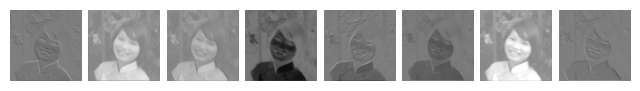

Layer output shape: torch.Size([1, 16, 128, 128])


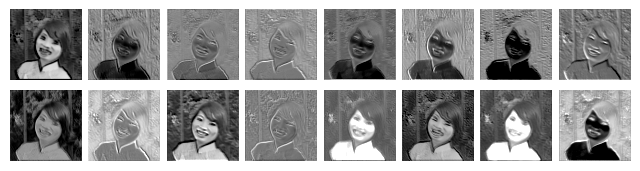

Layer output shape: torch.Size([1, 32, 64, 64])


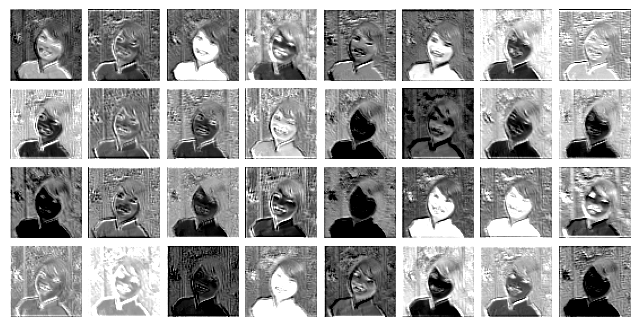

Layer output shape: torch.Size([1, 32, 32, 32])


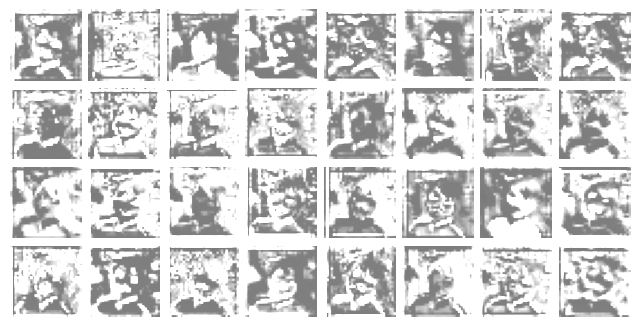

Layer output shape: torch.Size([1, 32, 32, 32])


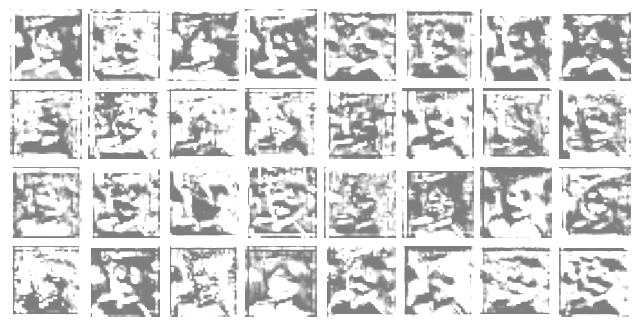

Layer output shape: torch.Size([1, 32, 32, 32])


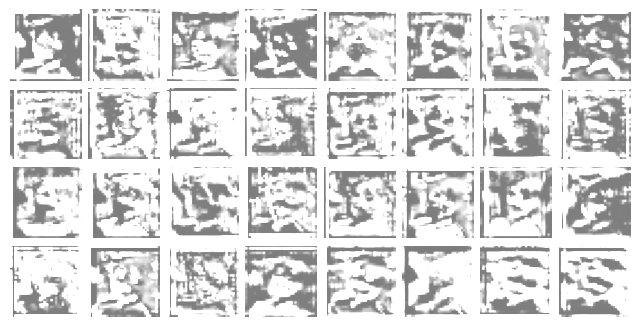

Layer output shape: torch.Size([1, 32, 32, 32])


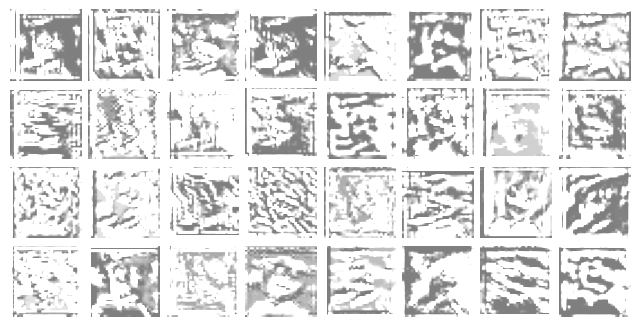

Layer output shape: torch.Size([1, 32, 32, 32])


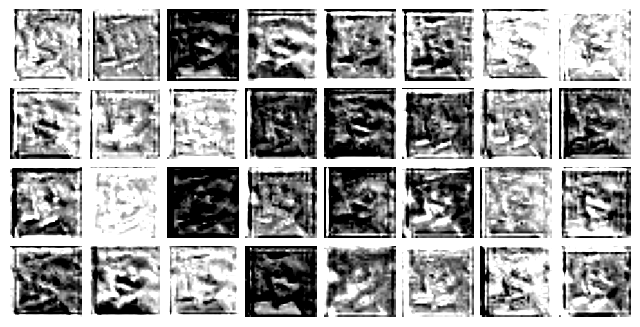

Layer output shape: torch.Size([1, 32, 16, 16])


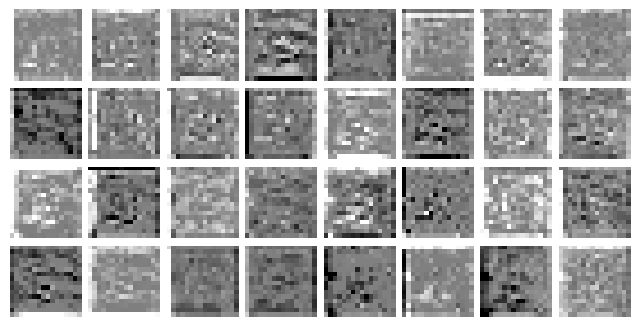

Layer output shape: torch.Size([1, 32, 16, 16])


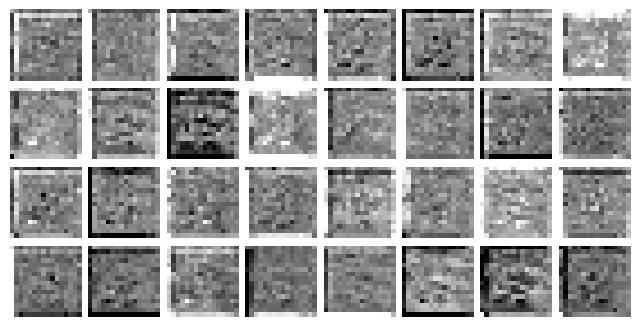

Layer output shape: torch.Size([1, 64, 8, 8])


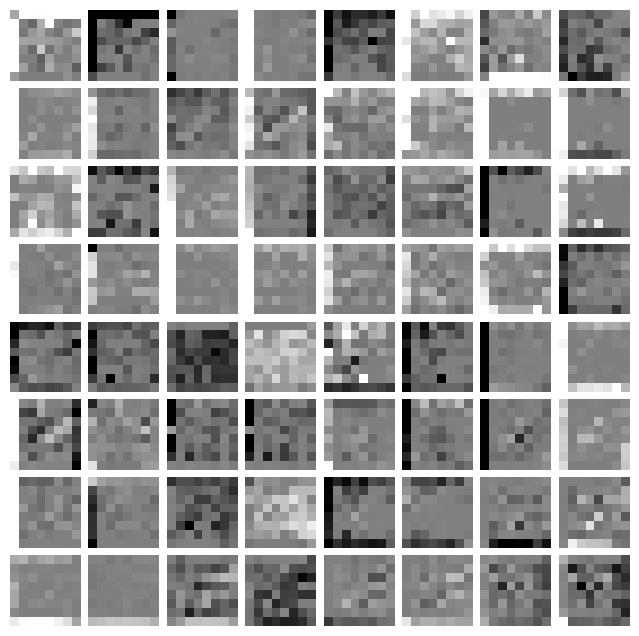

Layer output shape: torch.Size([1, 64, 8, 8])


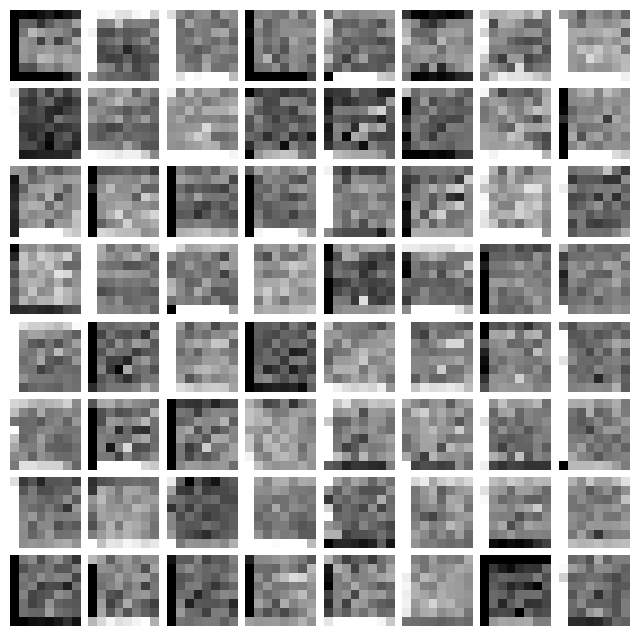

Layer output shape: torch.Size([1, 128, 4, 4])


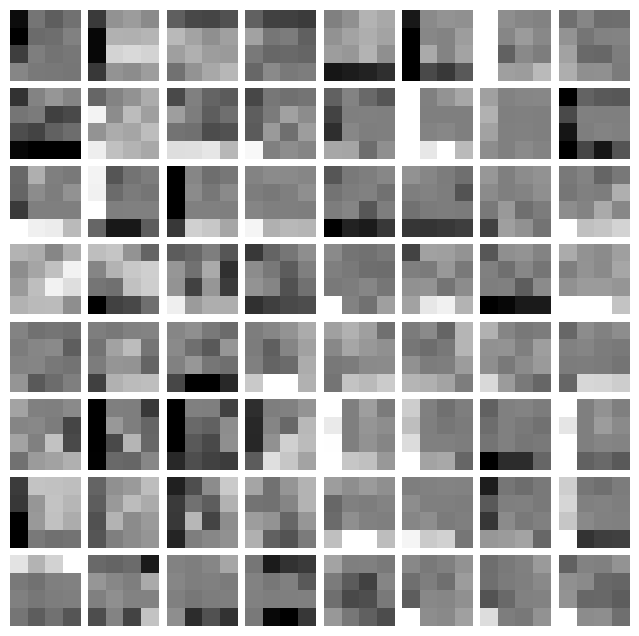

Layer output shape: torch.Size([1, 128, 4, 4])


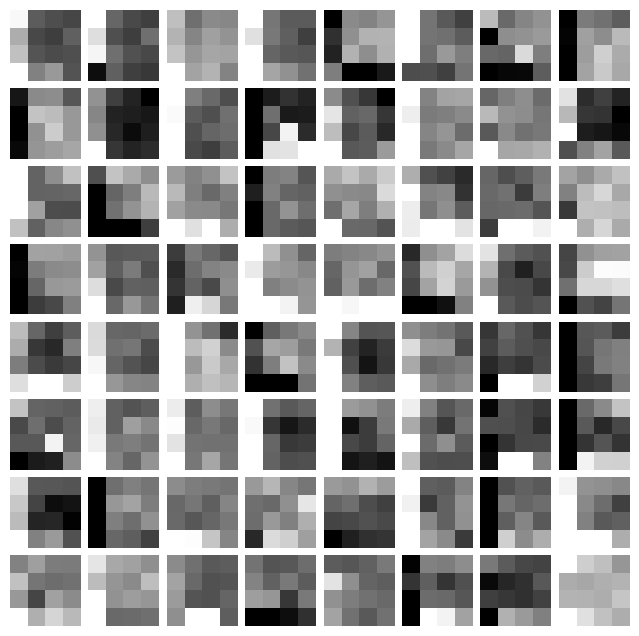

Layer output shape: torch.Size([1, 256, 2, 2])


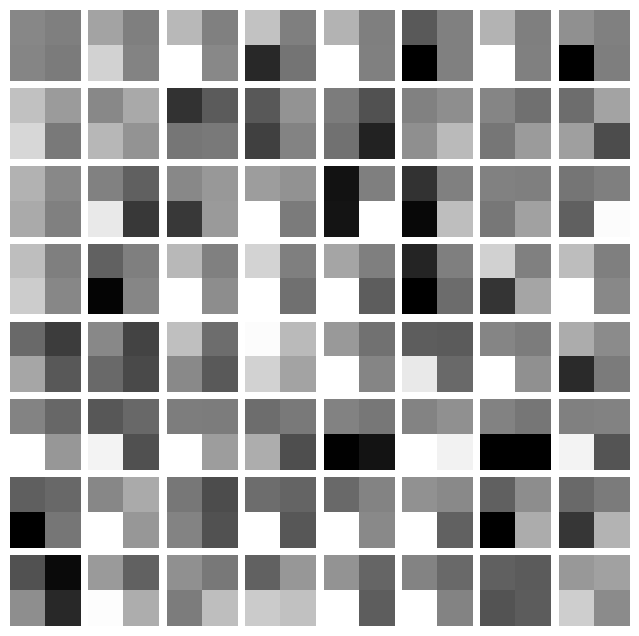

Layer output shape: torch.Size([1, 256, 2, 2])


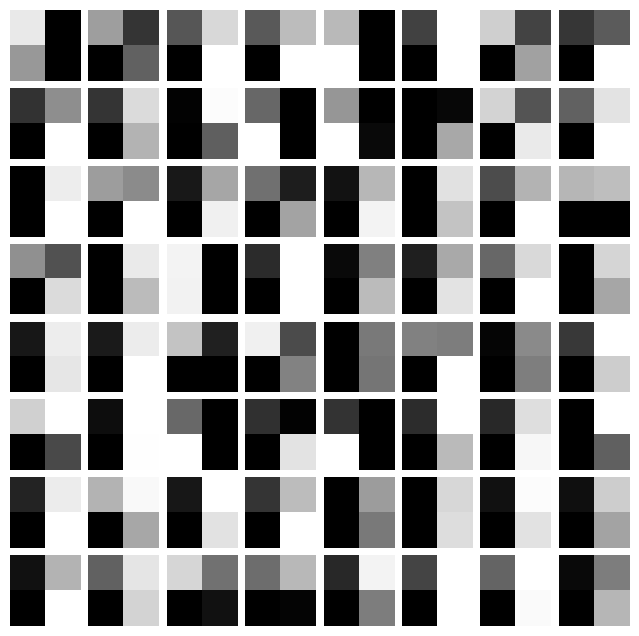

Layer output shape: torch.Size([1, 1024, 1, 1])


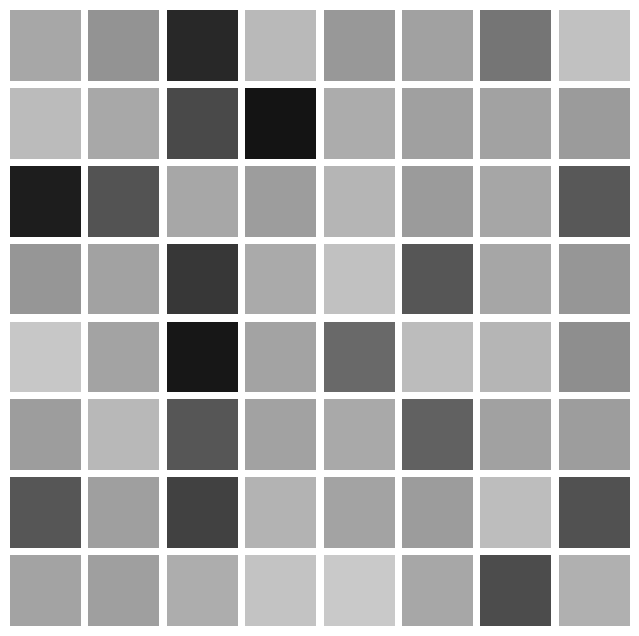

In [15]:
batch = next(iter(trainloader))
random_image = batch['image'].to(cfg['device'])[:1]

def plot_layer_output(layer, image):
    layer_output = layer(image) # shape [1, c, h, w]
    print('Layer output shape:', layer_output.shape)
    # cap at 64 channels
    if layer_output.shape[1] > 64:
        layer_output = layer_output[:, :64]
    
    if len(layer_output.shape) == 4:
        layer_output = layer_output.squeeze(0)
        
    if len(layer_output.shape) == 3:
        num_kernels = layer_output.shape[0]
        num_cols = 8
        num_rows = math.ceil(num_kernels / num_cols)
        fig = plt.figure(figsize=(num_cols, num_rows))
        for i in range(num_kernels):
            ax1 = fig.add_subplot(num_rows, num_cols, i+1)
            ax1.imshow(layer_output[i].cpu().detach().numpy(), cmap='gray', vmin=-1, vmax=1)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()


# conv indexes or residual block indexes
conv_indexes = [i for i, layer in enumerate(retinal_encoder.model) if isinstance(layer, nn.Conv2d) or isinstance(layer, ResidualBlock)]

# # plot the output of the first layer
for i in conv_indexes:
    plot_layer_output(retinal_encoder.model[:i+1], random_image)
